The iSTTC concat ACF in some units show strange behavior - the curve goes up at the last 2-3 lags, so the autocorrelation is getting high. 
Unit0 from PFdl has this (trail avg look fine).

Here check:
* load already calculated ACFs, plot on one grid, check values
* try "global" normalization - the T term is calculated based on the non shifted signal (concat trials without 0s)
* shifting the whole signal? 

In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

# import from scripts
import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from calculate_acf import acf_sttc_trial_concat_global, acf_sttc_trial_concat, acf_sttc_trial_concat_global_v2
from cfg_global import project_folder_path
os.chdir(current_wd)

In [2]:
results_folder = 'Q:\\Personal\\Irina\\projects\\isttc\\results\\monkey\\fixation_period_1000ms_no_empty\\'
data_folder = project_folder_path + 'results\\monkey\\'

#### load already calculated ACFs, plot on one grid, check values

In [5]:
area = 'pfdl'

n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags)]

acf_pearsonr_trial_avg_df = pd.read_pickle(results_folder + 'binned\\' + area + '\\acf\\acf_pearsonr_trial_avg_1000ms_no_empty_50ms_20lags_df.pkl')
acf_matrix_pearsonr_trial_avg_l = np.load(results_folder + 'binned\\' + area + '\\acf\\acf_matrix_pearsonr_trial_avg_1000ms_no_empty_50ms_20lags_df.npy')

acf_sttc_trial_avg_df = pd.read_pickle(results_folder + 'non_binned\\' + area + '\\acf\\acf_sttc_trial_avg_1000ms_no_empty_50ms_20lags_df.pkl')
acf_matrix_sttc_trial_avg_l = np.load(results_folder + 'non_binned\\' + area + '\\acf\\acf_matrix_sttc_trial_avg_1000ms_no_empty_50ms_20lags_df.npy')

acf_sttc_trial_concat_df = pd.read_pickle(results_folder + 'non_binned\\' + area + '\\acf\\acf_sttc_trial_concat_1000ms_no_empty_50ms_20lags_df.pkl')
#acf_sttc_trial_concat_fixed_df = pd.read_pickle(results_folder + 'non_binned\\' + area + '\\acf\\acf_sttc_trial_concat_fixed_1000ms_no_empty_50ms_20lags_df.pkl')
# acf_sttc_trial_concat_global_df = pd.read_pickle(results_folder + 'non_binned\\' + area + '\\acf\\acf_sttc_trial_concat_global_1000ms_no_empty_50ms_20lags_df.pkl')

#### try "global" normalization - the T term is calculated based on the non shifted signal (concat trials without 0s)

In [6]:
# non-binned data
csv_data_file = data_folder + 'data_' + area + '_fixon_1000ms_no_empty_fixation.csv'
with open(csv_data_file, newline='') as f:
    reader = csv.reader(f)
    sua_non_binned_list = list(reader)
    
n_non_binned_spike_trains = len(sua_non_binned_list)
print('N spike_trains in {}: {}'.format(area, n_non_binned_spike_trains))

# transform data to a dict, key is unit_id, values is a list of spike trains (one spike train per trial)
units_dict = {}
for spike_train in sua_non_binned_list:
    spike_train_ = np.asarray(spike_train[5:]).astype(int)
    # spike_train_1000 = spike_train_[spike_train_ <= 1000]
    if int(spike_train[0]) in units_dict:
        units_dict[int(spike_train[0])].append(spike_train_)
    else:
        units_dict[int(spike_train[0])] = []
        units_dict[int(spike_train[0])].append(spike_train_)

n_non_binned_units = len(units_dict)
print('n units {}'.format(n_non_binned_units))

N spike_trains in pfdl: 29367
n units 542


In [ ]:
# params for sttc
bin_size = 50
sttc_dt = 49
trial_len = n_lags * bin_size

acf_sttc_trial_concat_l = []
unit_id_calc_l = []

for k,v in units_dict.items():
    print('Processing unit {}, n trials {}'.format(k, len(v)))
    
    if len(v) <= 1:
        print('ONLY 1 TRIAL: can not calculate, skipping...')
    else:
        acf_concat = acf_sttc_trial_concat(v, n_lags_=n_lags, lag_shift_=bin_size, sttc_dt_=sttc_dt, trial_len_=trial_len,
                                           zero_padding_len_=3000, verbose_=False)
        acf_sttc_trial_concat_l.append(acf_concat)
        unit_id_calc_l.append(k)

acf_sttc_trial_concat_global_df = pd.DataFrame(np.array(acf_sttc_trial_concat_l), columns=acf_cols)
acf_sttc_trial_concat_global_df.insert(0, 'unit_id', unit_id_calc_l)

print('NaNs in acf {}'.format(acf_sttc_trial_concat_global_df.isnull().any().any()))
acf_sttc_trial_concat_global_df.head(3)

acf_sttc_trial_concat_global_df.to_pickle(results_folder + 'non_binned\\' + area + '\\acf\\acf_sttc_trial_concat_fixed_1000ms_no_empty_50ms_20lags_df.pkl')

In [ ]:
fig_folder = results_folder + '\\acf_line_plots\\pfp_one_plot_per_unit_wtf\\'

for unit_id in acf_pearsonr_trial_avg_df['unit_id'].values:

    fig, axes = plt.subplots(1,1, figsize=(5,4))
    
    # unit_id = 33
    
    axes.plot(acf_pearsonr_trial_avg_df.query('unit_id == @unit_id')[acf_cols].values[0], c='slategray', lw=0.5 ,marker='o', markersize='4', 
              label='personr_trial_avg')
    axes.plot(acf_sttc_trial_avg_df.query('unit_id == @unit_id')[acf_cols].values[0], c='steelblue', lw=0.5 ,marker='o', markersize='4', 
              label='sttc_trial_avg')
    axes.plot(acf_sttc_trial_concat_df.query('unit_id == @unit_id')[acf_cols].values[0], c='salmon', lw=0.5 ,marker='o', markersize='4', 
              label='sttc_trial_concat')
    axes.plot(acf_sttc_trial_concat_global_df.query('unit_id == @unit_id')[acf_cols].values[0], c='firebrick', lw=0.5 ,marker='o', markersize='4', 
              label='sttc_trial_concat_global')
    axes.plot(acf_sttc_trial_concat_fixed_df.query('unit_id == @unit_id')[acf_cols].values[0], c='teal', lw=0.5 ,marker='o', markersize='4', 
          label='sttc_trial_concat_wtf')

    axes.axhline(y=0, lw=0.5, c='k')
    
    axes.legend(frameon=False)
    
    fig.suptitle('acf, unit ' + str(unit_id))
    
    axes.set_ylabel('ACF (a.u.)')
    axes.set_xlabel('Time (ms)')
    axes.set_xticks(np.linspace(0, 20, 11).astype(int))
    axes.set_xticklabels(np.linspace(0, 1000, 11).astype(int))
    axes.set_xlim([0,20])
    
    sns.despine()
    
    fig.savefig(fig_folder + 'acf_1000ms_no_empty_50ms_20lags_unit_' + str(unit_id) + '.png' , bbox_inches='tight')
    plt.close()

#### Calculate isttc concat for one unit

In [18]:
unit = units_dict[33]
unit[:10]

[array([ 14,  40,  74, 117, 155, 183, 211, 221, 261, 304, 333, 430, 460,
        478, 500, 514, 547, 571, 602, 623, 638, 649, 664, 681, 706, 756,
        885]),
 array([ 49,  68,  92, 134, 210, 395, 444, 459, 490, 511, 536, 575, 729,
        767, 789, 916, 958]),
 array([  9,  41,  69,  73,  96, 110, 123, 135, 147, 173, 191, 227, 257,
        281, 307, 319, 337, 360, 366, 381, 403, 433, 442, 458, 471, 484,
        507, 539, 566, 577, 590, 614, 628, 639, 667, 685, 694, 717, 732,
        741, 752, 767, 787, 794, 801, 806, 817, 832, 867, 881, 895, 922,
        947, 957, 976]),
 array([ 10,  62, 174, 191, 302, 631, 765, 815, 889, 912]),
 array([ 13,  49,  83, 144, 156, 205, 231, 267, 296]),
 array([ 26, 429, 460, 503, 632, 685, 743, 815, 884, 926, 940, 960]),
 array([ 88, 216, 228, 331, 389, 459, 520, 565, 670, 764, 856, 878, 895,
        916, 951]),
 array([  1,  18,  37, 101, 107, 135, 148, 164, 173, 195, 217, 229, 264,
        285, 310, 318, 337, 351, 360, 371, 393, 397, 408, 414, 423, 

In [24]:
bin_size = 50
sttc_dt = 49
trial_len = n_lags * bin_size

unit = units_dict[0]
acf_concat = acf_sttc_trial_concat_global_v2(unit[:10], n_lags_=n_lags, lag_shift_=bin_size, sttc_dt_=sttc_dt, trial_len_=trial_len,
                                   zero_padding_len_=3000, verbose_=True)

Processing 10 trials: n lags 20, lag shift 50, sttc dt 49, zero padding len 3000
sttc_calculate_t  spiketrain [ 20  71 205 219 247 328 380 394 428 475 763 796], n spikes 12
Initial time_abs: 1176
Adjusted time_abs: 619
Total time: 1000, Time proportion: 0.619
sttc_calculate_t  spiketrain [ 15  99 139 182 287 417 452 500 779 878 893], n spikes 11
Initial time_abs: 1078
Adjusted time_abs: 721
Total time: 1000, Time proportion: 0.721
sttc_calculate_t  spiketrain [ 43 188 379 417 440 465 485 512 533 556 596 627 799 883 890 953], n spikes 16
Initial time_abs: 1568
Adjusted time_abs: 786
Total time: 1000, Time proportion: 0.786
sttc_calculate_t  spiketrain [ 53  67 110 139 156 167 193 234 267 300 318 339 348 367 385 398 416 445
 456 481 491 524 551 594 633 664 689 719 776 797 808 834 866 913 935 973], n spikes 36
Initial time_abs: 3528
Adjusted time_abs: 996
Total time: 1000, Time proportion: 0.996
sttc_calculate_t  spiketrain [143 247 806 842 860 913 962 989], n spikes 8
Initial time_abs: 7

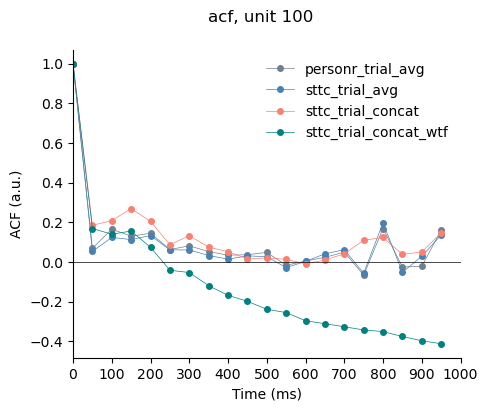

In [23]:
fig, axes = plt.subplots(1,1, figsize=(5,4))
    
unit_id = 100

axes.plot(acf_pearsonr_trial_avg_df.query('unit_id == @unit_id')[acf_cols].values[0], c='slategray', lw=0.5 ,marker='o', markersize='4', 
          label='personr_trial_avg')
axes.plot(acf_sttc_trial_avg_df.query('unit_id == @unit_id')[acf_cols].values[0], c='steelblue', lw=0.5 ,marker='o', markersize='4', 
          label='sttc_trial_avg')
axes.plot(acf_sttc_trial_concat_df.query('unit_id == @unit_id')[acf_cols].values[0], c='salmon', lw=0.5 ,marker='o', markersize='4', 
          label='sttc_trial_concat')
# axes.plot(acf_sttc_trial_concat_global_df.query('unit_id == @unit_id')[acf_cols].values[0], c='firebrick', lw=0.5 ,marker='o', markersize='4', 
#           label='sttc_trial_concat_global')
axes.plot(acf_concat, c='teal', lw=0.5 ,marker='o', markersize='4', 
          label='sttc_trial_concat_wtf')

axes.axhline(y=0, lw=0.5, c='k')

axes.legend(frameon=False)

fig.suptitle('acf, unit ' + str(unit_id))

axes.set_ylabel('ACF (a.u.)')
axes.set_xlabel('Time (ms)')
axes.set_xticks(np.linspace(0, 20, 11).astype(int))
axes.set_xticklabels(np.linspace(0, 1000, 11).astype(int))
axes.set_xlim([0,20])

sns.despine()

In [ ]:
acf_concat_global = acf_sttc_trial_concat_global(unit[:10], n_lags_=n_lags, lag_shift_=bin_size, sttc_dt_=sttc_dt, trial_len_=trial_len,
                                   zero_padding_len_=3000, verbose_=True)